# Подготовка

In [1]:
# !ls dl-course/lecture6


In [2]:
!git clone https://github.com/stepanovnick/dl-course.git

Cloning into 'dl-course'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 122 (delta 24), reused 87 (delta 16), pack-reused 25 (from 1)
Receiving objects: 100% (122/122), 58.31 MiB | 13.69 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [3]:
%cd dl-course/lecture6/workshop_detection

/content/dl-course/lecture6/workshop_detection


In [ ]:
!gdown "https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF" -O seminar_objdet_retina_oi5_ball.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF
From (redirected): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF&confirm=t&uuid=916e35ad-9cc0-4d36-b082-e7db2a09cab7
To: /content/dl-course/lecture6/seminar_objdet_retina_oi5_ball.zip
100% 1.08G/1.08G [00:04<00:00, 247MB/s]


In [ ]:
!unzip seminar_objdet_retina_oi5_ball.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/2688.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._2688.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1381.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1381.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0921.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0921.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0909.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0909.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/3025.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._3025.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1626.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1626.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0538.jpg  
  inflating: __MACOSX/seminar_objd



## Курс Нейронные сети в машинном обучении"

### Семинар 6: Реализация Single-shot Object Detection на примере RetinaNet

Сегодня мы рассмотрим реализацию архитектуры RetinaNet для детектирования объектов за один проход.

#### Материалы для чтения:
1. Оригинальная статья про RetinaNet: [Focal Loss for Dense Object Detection](https://arxiv.org/pdf/1708.02002.pdf)
2. Статья о подходе FPN: [Feature Pyramid Networks for Object Detection](https://arxiv.org/pdf/1612.03144.pdf)
3. Источники кода для семинара: [github/yhenon/pytorch-retinanet](https://github.com/yhenon/pytorch-retinanet), [github/lysukhin/vk-academy-dl-cv](https://github.com/lysukhin/vk-academy-dl-cv)
4. Пост [RetinaNet Explained and Demystified](https://blog.zenggyu.com/en/post/2018-12-05/retinanet-explained-and-demystified/)

#### План
1. Подходы к детектированию
2. Реализация компонентов RetinaNet
3. Дообучение RetinaNet

### 1. Подходы к детектированию

#### Region-based

* Детектирование на основе регионов (region-based):
  * Отдельная голова для предсказания возможных областей с объектами (Region Proposal Network, RPN)
  * Отдельные головы для классификации и уточнения границ регионов
  * Все головы работают поверх признаков, извлеченных "базовой" моделью (она же *backbone*, она же *ствол* и т.д.)
  * Полученные прямоугольники объектов фильтруются с помощью процедуры *Non-maxima suppression (NMS)*
  * Пример: [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf) (из семейства R-CNN):
      * Признаки вычисляются один раз и являются "общими" для всех ветвей
      * Голова RPN получает на вход кропы, заданные набором "якорных" прямоугольников (они же *anchor boxes*, *default boxes*, *proposals*, ...)
      * Для каждого кропа предсказывается вероятность содержания в нем объекта и уточняющие координаты границ
      * Отобранные якорные прямоугольники поступают на вход ветвей классификации и регрессии
  
      ![faster_rcnn](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img1_fastrcnn.png?raw=1)

#### Single shot

* Детектирование "в один проход" (single-shot):
  * Идея с якорными прямоугольниками остается
  * Фактически, перенесли головы для классификации и регресии сразу внутрь RPN
  * Предсказания классов и уточняющих координат производится сразу для всех якорей
  * Пример: [Single Shot Multibox Detector](https://arxiv.org/pdf/1512.02325.pdf)
    * Предсказания собираются с разных глубин базовой сети
    
    ![ssd](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img2_ssd.png?raw=1)

#### RetinaNet:

Ключевые особенности RetinaNet:
* Использование специальной функции потерь (*Focal Loss*)
  * для борьбы с дисбалансом классов при обучении (обычно "объектов" на изображении меньше, чем "фона")
* Комбинирование признаков с разных глубин сети  (*Features Pyramid*)
  * для "уравнивания" семантической силы нейронов на разных масштабах

### 2. Реализация компонентов RetinaNet

In [ ]:
!pip install -r requirements.txt

In [4]:
import os
import sys
import cv2
import json
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torchvision.transforms.functional import to_tensor, normalize

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)


from visualization import show_image, draw_predictions

Device is: cpu


Подгрузим тестовое изображение и сделаем из него батч размера 1. Это пригодится нам для демонстрации работы отдельных компонентов модели.

In [ ]:
def make_tensor(image, device=None):
    tensor = to_tensor(image).unsqueeze(0)
    tensor = normalize(tensor,
                       mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225))
    if device:
        tensor = tensor.to(device)
    return tensor

Image shape (540, 800, 3)
Tensor size torch.Size([1, 3, 540, 800])


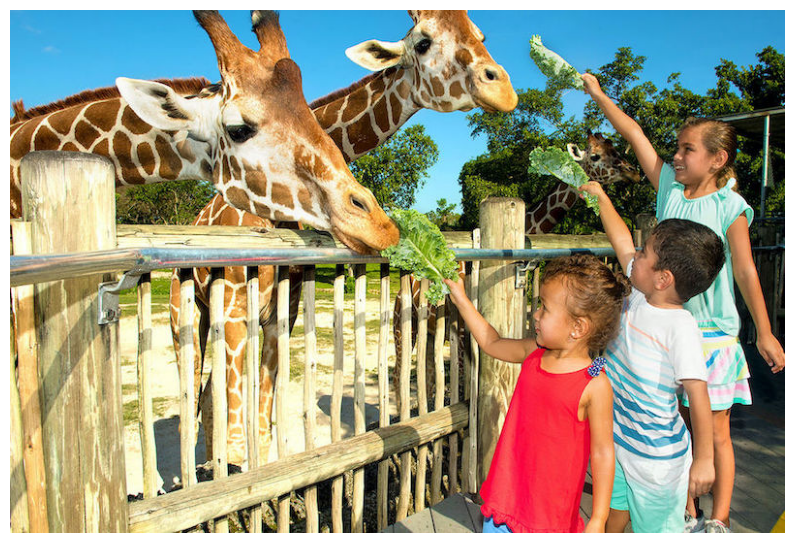

In [ ]:
image_example = cv2.imread("images/zoo.jpg")


image_example = cv2.cvtColor(image_example, cv2.COLOR_BGR2RGB)
print("Image shape", image_example.shape)

tensor_example = make_tensor(image_example, device)
print("Tensor size", tensor_example.size())

show_image(image_example)

---

Поскольку модель имеет несколько отдельных модулей, реализуем их и положим в один композиционный класс:

- `RetinaNet`
  - `.backbone` - нейросеть для извлечения признаков; модифицированный `ResNet`, возвращающий карты активаций (вместо логитов);
  - `.fpn` - нейросеть для построения пирамиды признаков из выходов `.backbone`;
  - `.anchor_generator` - класс для построения наборов "якорных" боксов (anchors), на основе которых будет производится поиск объектов;
  - `.cls_head` - нейросеть для классификации каждого из anchor boxes;
  - `.reg_head` - нейросеть для регрессии уточняющих коэффициентов координат каждого из anchor boxes;
  - `.focal_loss` - реализация лосс-функции (да, ее можно поместить прямо в модель).

---

#### Backbone: Модифицированный ResNet

ResNet - семейство архитектур, у которого главная вычислительная единица - это т.н. residual-block:

![residuals](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img3_resnet.png?raw=1)

Модели `ResNet-*` состоят из блоков, объединенных в четыре слоя (`layerX`); между слоями происходит 1) понижение размерности HW и 2) увеличение "ширины" блоков (число каналов в картах).

**NB: картинка ниже - для сети ResNet-34, в которой используются "простые" all-3x3 residual-блоки, как на картинке выше слева. В ResNet-50 используются `bottleneck`-блоки (соответственно сверху справа).
Число слоев у этих моделей одинаковое (а вот число блоков в слоях и их ширина отличаются).**

![resnet34](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img4_resnet.png?raw=1)

Обычно (для задач типа классификации или регрессии) на выходе модели оказывается вектор (размера `C` = числу классов или 1 - для регрессии).
Но для задачи детектирования понадобятся промежуточные карты активаций, на основе который будет построена пирамида.
На рисунке выше указаны карты `C3`, `C4` и `C5` - их и должен вернуть метод `.forward` нашей базовой сети.

**Задание**: реализовать метод `.forward()`, который должен возвращать карты активаций после слоев `layer2`, `layer3`, `layer4` в виде списка/кортежа.

In [ ]:
from retinanet.utils import BasicBlock, Bottleneck  # See code

class ResNet(nn.Module):

    def __init__(self, num_classes, block, layers_sizes):
        """
        ResNet constructor.

        Args:
            - num_classes: int number of outputs for model.
            - block: class to use as residual block in model (BasicBlock or Bottleneck).
            - layers_sizes: list of sizes (number of blocks) for each of the 4 layers.
        """
        self.inplanes = 64
        super(ResNet, self).__init__()

        # Input convolution: larger (7x7) and with increased stride (2).
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Four layers with residual blocks. Each layer has similar structure
        self.layer1 = self._make_layer(block, 64, layers_sizes[0])
        self.layer2 = self._make_layer(block, 128, layers_sizes[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers_sizes[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers_sizes[3], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride=1):
        """
        Method to create layer for ResNet using residual blocks.

        Args:
            - block: class to use as residual block in model (BasicBlock or Bottleneck).
            - planes: number of channels in layer's activation maps (also known as layer 'width').
            - num_blocks: number of blocks in layer.

        Returns:
            nn.Sequential object containing residual blocks.
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, num_blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, inputs):
        """
        Method for "__call__".

        Args:
            - inputs: batch of images shaped Bx3xHxW.

        Returns:
            List of feature maps tensors from layers 2, 3, 4.
        """

        # TODO:
        # Write code to run all the model layers (do not forget to run input convolution/bn/activation/pooling)
        # and to return feature maps from layer2, layer3, layer4.

        ### YOUR CODE HERE
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x2 = self.layer2(x)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        ### END OF YOUR CODE

        return (x2, x3, x4)

In [ ]:
num_classes = 80

print("ResNet50:")
resnet50_layers_sizes = [3, 4, 6, 3]
resnet50 = ResNet(num_classes=num_classes, block=Bottleneck, layers_sizes=resnet50_layers_sizes).to(device)

print(resnet50)

ResNet50:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [ ]:
print("Feature maps sizes from layer2-4 of ResNet50:")
feature_maps_example = resnet50(tensor_example)
for fm in feature_maps_example:
    print(fm.size())

Feature maps sizes from layer2-4 of ResNet50:
torch.Size([1, 512, 68, 100])
torch.Size([1, 1024, 34, 50])
torch.Size([1, 2048, 17, 25])


---

#### Feature Pyramid: собираем пирамиду активаций

Теперь перейдем к модулю, который сделает из последовательности карт активаций пирамиду.

Идея `Feature Pyramid` в том, чтобы, скомбинировав карты с разных слоев основной сети (`backbone`), получить карты одновременно "семантически богатые" и с большим рецептивным полем.

![fpn](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img5_fpp.png?raw=1)

На рисунке выше изображена пирамида из 3 уровней. Авторы [оригинальной статьи](https://arxiv.org/pdf/1708.02002.pdf) указывают (примечание на стр.4), что в их пирамиде 5 слоев, которые обозначаются от $P_3$ до $P_7$. При этом соответствие слоев пирамиды картам активации такое: $C_3 - P_3$, $C_4 - P_4$, $C_5 - P_5$, а два дополнительных слоя пирамиды $P_6$ и $P_7$ получаются последовательно свертками из $P_5$ (уже без сложения с низкоуровневыми картами)

Каждая из карт $C_i$ ($C_5$ - $C_3$):
1. Сворачивается с ядром 1х1, получается $C'_i$
2. Суммируется с выходной картой выше $C'_{i+1}$ (нет у $C_5$), увеличенной вдвое, и после свертки с ядром 3х3 отправляется на выход ($P_i$).

**Задание**: реализовать кусок метода `.forward()` для вычисления `P3` (по аналогии с `P5` & `P4`).

In [ ]:
class PyramidFeatures(nn.Module):

    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        """
        FPN constructor.

        Args:
            - C3_size: num features in C3 map.
            - C4_size: num features in C4 map.
            - C5_size: num features in C5 map.
            - feature_size: num features in output maps.
        """
        super(PyramidFeatures, self).__init__()

        # For P5
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # For P4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # For P3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # For P6
        # "P6 is obtained via a 3x3 stride-2 conv on C5"
        self.P6 = nn.Conv2d(C5_size, feature_size, kernel_size=3, stride=2, padding=1)

        # For P7
        # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
        self.P7_1 = nn.ReLU()
        self.P7_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

    def forward(self, inputs):
        """
        Method for "__call__".

        Args:
            - inputs: List of C3, C4, C5 activation maps from backbone.

        Returns:
            List of pyramid feature maps from P3 to P7.
        """
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        # TODO:
        # Write code to compute P3_x output map.
        # Almost like P4_x & P5_x, but no need for upsampling itself
        # (as we do not have 'lower' map P2)

        # YOUR CODE HERE
        P3_x = self.P3_1(C3)
        P3_x = P4_upsampled_x + P3_x
        P3_x = self.P3_2(P3_x)

        # END OF YOUR CODE

        P6_x = self.P6(C5)

        P7_x = self.P7_1(P6_x)
        P7_x = self.P7_2(P7_x)

        return (P3_x, P4_x, P5_x, P6_x, P7_x)

In [ ]:
fpn_sizes = (512, 1024, 2048)  # ResNet50
fpn = PyramidFeatures(*fpn_sizes).to(device)

print("Feature pyramid sizes:")
features_pyramid_example = fpn(feature_maps_example)
for fp in features_pyramid_example:
    print(fp.size())

Feature pyramid sizes:
torch.Size([1, 256, 68, 100])
torch.Size([1, 256, 34, 50])
torch.Size([1, 256, 17, 25])
torch.Size([1, 256, 9, 13])
torch.Size([1, 256, 5, 7])


In [ ]:
68 * 100 * 9

61200

Обратим внимание:
* У первого слоя (который мы называем $P_3$) линейные размеры в 8 = $2^3$ раз меньше, чем у оригинального изображения.
* На каждом слое пирамиды линейные размеры уменьшаются вдвое.

То есть размеры слоя $P_i$ меньше размеров исходного изображения в $2^i$ раз.

---

На данный момент у нас есть инструменты для извлечения карт признаков из изображения.

Теперь, если бы мы работали в парадигме, например, `Fast R-CNN` (не надо так), мы бы запустили на этих признаках алгоритм `SelectiveSearch`, получили координаты предполагаемых локаций с объектами (в виде обрамляющих прямоугольников), "вырезали" их проекции из каждого слоя пирамиды признаков и подали в подсети для определения классов и регрессии относительных координат.

Но, поскольку мы работаем в парадигме single-shot-детектирования, мы сделаем все за один проход.
С каждым супер-пикселем любого из слоев пирамиды (супер-пиксель - это одна точка (x, y) на карте признаков) мы ассоциируем некоторую область на исходном изображении, и для каждой такой области назначим набор т.н. `proposals`, то есть предполагаемых обрамляющих прямоугольников, лежащих в этой области.

![subnet2](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img6_grid.jpeg?raw=1) ![subnet](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img6_grid2.jpeg?raw=1)


Эти наборы нужны для того, чтобы связать суперпиксели активационных карт с ground-truth объектами при обучении.

---

#### Anchors generator

В качестве основы для набора `proposals` возьмем три прямоугольника: "горизонтальный" (соотношение сторон H:W = 1:2, в коде - `ratio`), "квадрат" (H:W = 1:2) и "вертикальный" (H:W = 2:1).

Если кроме 3 вариантов соотношения сторон взять 3 варианта для масштаба, получим набор из 9 прямоугольников.

![1](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img7_anchors.png?raw=1)


После того, как зафиксирован набор `proposals` для одного супер-пикселя, нужно отобразить все прямоугольники (для всех супер-пикселей на всех уровнях пирамиды) на исходное изображение, чтобы связать их с ground-truth прямоугольниками объектов.

Класс `AnchorsGenerator` нужен затем, чтобы сгенерировать наборы `proposals` для всех слоев, раскидать их по сетке и спроецировать на исходное изображение.

**NB: Конкретные положения прямоугольников зависят как от гипер-параметров генератора, так и от размеров изображения!**

In [ ]:
from retinanet.anchors import generate_anchors, shift


class AnchorsGenerator(nn.Module):

    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None, device=None):
        """
        AnchorGenerator constructor.

        Args:
            - pyramid_levels: list of log_2(image_width / pyramid_level_width) for every pyramid level.
            - strides: list of step sizes for sliding each anchor box set for every pyramid level.
            - sizes: list of basic sizes for anchor boxes for every pyramid level.
            - ratios: list of anchor boxes aspect ratio sets for every pyramid level.
            - scales: list of anchor boxes scale sets for every pyramid level.
            - device: device to move results to.
        """
        super(AnchorsGenerator, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
        if ratios is None:
            self.ratios = np.array([0.5, 1, 2])
        if scales is None:
            self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

        if device is None:
            device = torch.cuda.is_available() and 'cuda' or 'cpu'
        self.device = device

    def forward(self, image, verbose=False):
        """
        Method for "__call__".

        Args:
            - image: tensor of shape B x C x H x W.

        Returns:
            tensor of computed anchor box coordinatates, size total_num_anchors x 4.
        """
        image_shape = image.shape[2:]  # h, w
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        # Compute anchors over all pyramid levels

        all_anchors = np.zeros((0, 4)).astype(np.float32)

        for idx, p in enumerate(self.pyramid_levels):

            # Generate 9 anchors
            anchors = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)

            # Grid all over the shape with stride
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)

            if verbose:
                print(f"{idx}\tpyr_level = {p}\tstride = {self.strides[idx]:3d}\tsize={self.sizes[idx]:3d}\tanchors shape = {shifted_anchors.shape}")

            all_anchors = np.append(all_anchors, shifted_anchors, axis=0)

        all_anchors = np.expand_dims(all_anchors, axis=0)

        return torch.from_numpy(all_anchors.astype(np.float32)).to(self.device)

In [ ]:
anchors_generator = AnchorsGenerator(device=device)

anchors_example = anchors_generator(tensor_example, verbose=True)[0].cpu()
print()
print(anchors_example.size())

0	pyr_level = 3	stride =   8	size= 32	anchors shape = (61200, 4)
1	pyr_level = 4	stride =  16	size= 64	anchors shape = (15300, 4)
2	pyr_level = 5	stride =  32	size=128	anchors shape = (3825, 4)
3	pyr_level = 6	stride =  64	size=256	anchors shape = (1053, 4)
4	pyr_level = 7	stride = 128	size=512	anchors shape = (315, 4)

torch.Size([81693, 4])


Получили общее число `proposals`, каждый из которых задается четырьмя числами - x1, y1, x2, y2.

Отрисуем по несколько полученных прямоугольников с каждого слоя на исходном изображении.

5


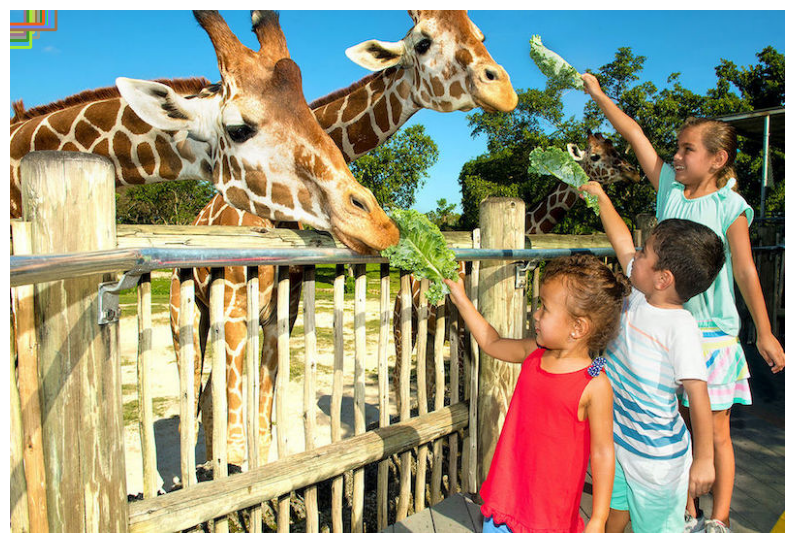

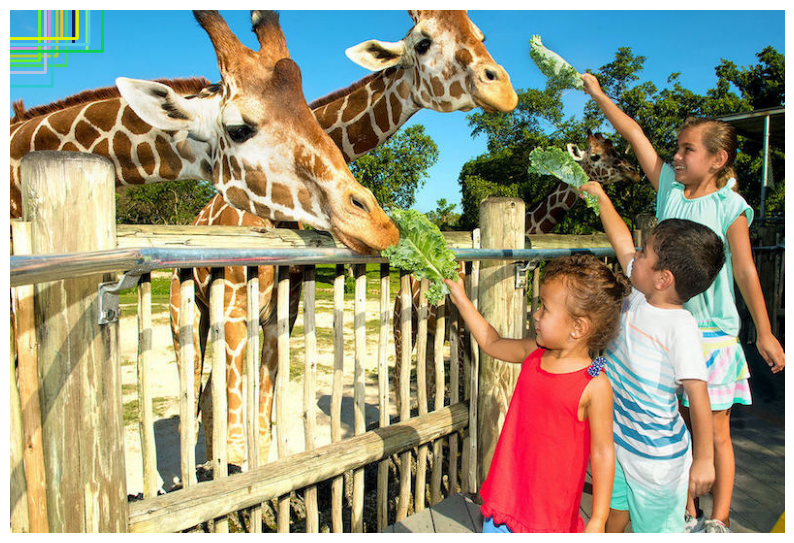

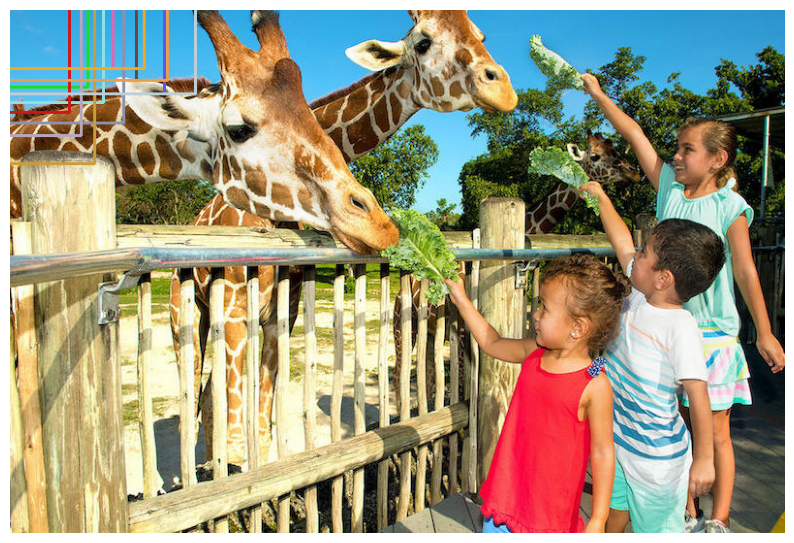

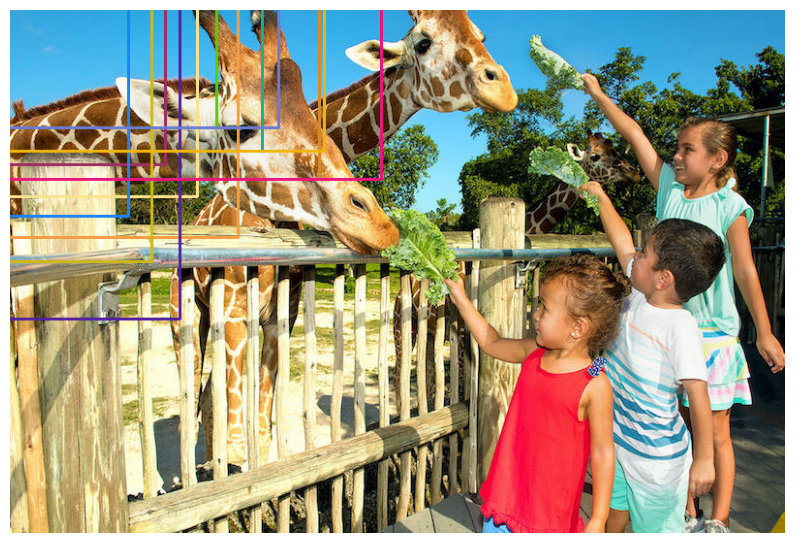

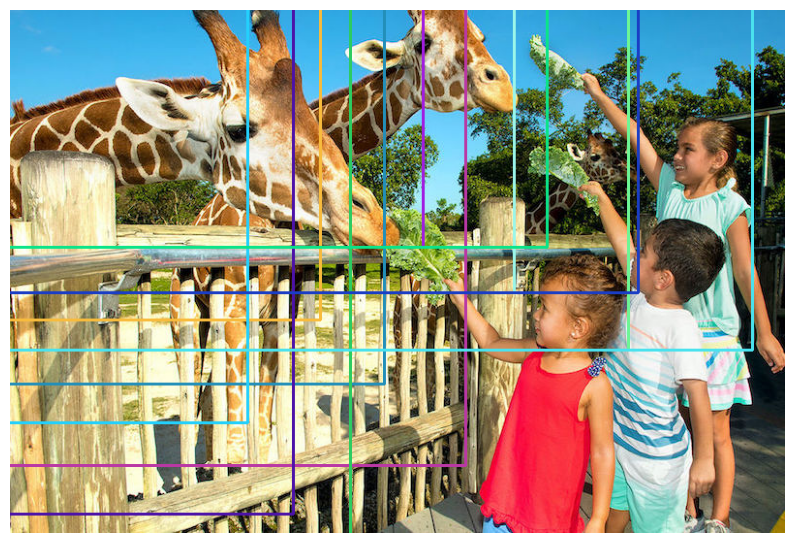

In [ ]:
anchors_num_per_level = [61200, 15300, 3825, 1053, 315]
anchors_per_level = np.split(anchors_example, np.cumsum(anchors_num_per_level)[:-1])
print(len(anchors_per_level))


num_to_show = 32
### Итерируемся по каждому уровню
for anchor_boxes_level in anchors_per_level:
    image_example_with_anchors = image_example.copy()
    # for i in np.random.choice(len(anchor_boxes_level), size=num_to_show):
    # for i in range(len(anchor_boxes_level)):
    for i in range(12):
        anchor_box = anchor_boxes_level[i]
        x1, y1, x2, y2 = anchor_box.numpy().astype(np.int32)
        cv2.rectangle(image_example_with_anchors, (x1, y1), (x2, y2), np.random.randint(255, size=3).tolist(), 2)

    show_image(image_example_with_anchors)

Теперь, когда у нас есть модуль для генерации якорных прямоугольников, можем перейти к сеткам для классификации и регрессии на их основе.

---

#### Regression & Classification subnets

Классификацию (объект одного из классов или фон) и регрессию (уточнение координат объекта относительно `anchor box`) будет делать в сверточной манере.

![overall](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img8_reg_clf.png?raw=1)

* Регрессия

Поскольку с каждым супер-пикселем у нас ассоциировано 9 разных `proposals`, каждый из которых задан с помощью 4 чисел, то для регрессии нам потребуется 9 x 4 = 36 чисел в каждом суперпикселе. Значит, сделаем полносверточную сеть, которая не меняет размера карт активаций (то есть нет `pooling`-слоев и `stride`=1) и имеет на выходе 36 каналов. Таким образом, в каждом из `HxW` суперпикселей выходной карты будут храниться все необходимые таргеты.

**Задание:** напишите код для преобразования тензора с результатами из вида `B x (num_anchors * 4) x H x W` к виду `B x total_num_anchors x 4`.

In [ ]:
class RegressionModel(nn.Module):

    def __init__(self, num_features_in, num_anchors=9, feature_size=256):
        """
        RegressionModel consctructor.

        RegressionModel is a fully-convolutional neural network that takes single feature pyramid level and
        outputs tensor of size total_number_of_anchors x 4.

        Args:
            - num_features_in: number of channels in every feature pyramid level.
            - num_anchors: size of anchor boxes set.
            - feature_size: size of internal activation maps.
        """
        super(RegressionModel, self).__init__()

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * 4, kernel_size=3, padding=1)

    def forward(self, x):
        """
        Run regression on single feature pyramid level.

        Args:
            - x: feature pyramid level of shape B x num_features_in x H x W.

        Returns:
            tensor of size B x (H * W * num_anchors) x 4.
        """
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)
        # out is B x C x H x W, with C = 4 * num_anchors

        # TODO: change shape of `out` tensor to be `B x total_num_anchors x 4`.

        # YOUR CODE HERE
        B, C, H, W = out.shape
        out = out.permute(0, 2, 3, 1)
        out = out.reshape(B, -1, 4)


        # END OF YOUR CODE

        return out

In [ ]:
num_features_in = 256
regression_head = RegressionModel(num_features_in).to(device)

regression_predictions = []
for features in features_pyramid_example:
    regression_predictions_at_level = regression_head(features)
    regression_predictions.append(regression_predictions_at_level)
    print(f"input: {features.size()}\t output: {regression_predictions_at_level.size()}")
regression_predictions = torch.cat(regression_predictions, dim=1) # batch x anchors x 4 [4 for bbox]

input: torch.Size([1, 256, 68, 100])	 output: torch.Size([1, 61200, 4])
input: torch.Size([1, 256, 34, 50])	 output: torch.Size([1, 15300, 4])
input: torch.Size([1, 256, 17, 25])	 output: torch.Size([1, 3825, 4])
input: torch.Size([1, 256, 9, 13])	 output: torch.Size([1, 1053, 4])
input: torch.Size([1, 256, 5, 7])	 output: torch.Size([1, 315, 4])


* Классификация

Архитектурно голова классификации идентична голове регрессии, отличие только в размере выхода (и активации): модель возвращает столько значений для каждого бокса, сколько классов в датасете, причем с активацией `Sigmoid`.

In [ ]:
class ClassificationModel(nn.Module):

    def __init__(self, num_features_in, num_anchors=9, num_classes=80, prior=0.01, feature_size=256):
        """
        ClassificationModel consctructor.

        ClassificationModel is a fully-convolutional neural network that takes single feature pyramid level and
        outputs tensor of size total_number_of_anchors x num_classes.

        Args:
            - num_features_in: number of channels in every feature pyramid level.
            - num_anchors: size of anchor boxes set.
            - num_classes: number of classes in dataset (do not count the `background` class!).
            - prior: float number to use in weights initializatin.
            - feature_size: size of internal activation maps.
        """
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        """
        Run classification on single feature pyramid level.

        Args:
            - x: feature pyramid level of shape B x num_features_in x H x W.

        Returns:
            tensor of size B x (H * W * num_anchors) x num_classes.
        """
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)
        out = self.output_act(out)
        # out is B x C x W x H, with C = num_classes * num_anchors

        out1 = out.permute(0, 2, 3, 1)
        batch_size, width, height, channels = out1.shape
        out2 = out1.reshape(batch_size, width, height, self.num_anchors, self.num_classes)

        return out2.reshape(x.shape[0], -1, self.num_classes)

In [ ]:
classification_head = ClassificationModel(num_features_in, num_classes=num_classes).to(device)
classification_results = []

for feature in features_pyramid_example:
    classification_results_at_level = classification_head(feature)
    classification_results.append(classification_results_at_level)
    print(f"input: {feature.size()}\t output: {classification_results_at_level.size()}")
classification_results = torch.cat(classification_results, dim=1) # batch x anchors x classes

input: torch.Size([1, 256, 68, 100])	 output: torch.Size([1, 61200, 80])
input: torch.Size([1, 256, 34, 50])	 output: torch.Size([1, 15300, 80])
input: torch.Size([1, 256, 17, 25])	 output: torch.Size([1, 3825, 80])
input: torch.Size([1, 256, 9, 13])	 output: torch.Size([1, 1053, 80])
input: torch.Size([1, 256, 5, 7])	 output: torch.Size([1, 315, 80])


Теперь мы можем объединить все в одну композицию, класс `RetinaNet`.

---

#### RetinaNet

In [ ]:
from retinanet.utils import BBoxTransform, ClipBoxes
from retinanet.losses import FocalLoss
from torchvision.ops import nms

Из интересного: метод `.forward()` работает по разному во время обучения и во время инференса:
- Во время обучения (`self.training = True`) функция возвращает список из двух лоссов - регрессионного и классификационного.
- Во время инференса функция возвращает предсказания: скоры, индексы классов и координаты боксов.

Как было сказано ранне основной фичей RetinaNet является Focal loss ([paper](https://arxiv.org/pdf/1708.02002.pdf)):

$$\text{FL}(p_t) = -(1-p_t)^\gamma \log p_t$$

где $p_t = \text{sigmoid}(x)$ для позитивного класса и $p_t = 1- \text{sigmoid}(x) = \text{sigmoid}(-x)$ для негативного.

Также помимо уже разобранных модулей будут использоваться:
- `BBoxTransform`: класс для сборки боксов из предсказаний регрессионной головы и набора якорных боксов.
- `ClipBoxes`: класс для усечения координат боксов при выходе за границы изображения.
- `FocalLoss`: класс для вычисления сложной функции потерь (на самом деле, в нем вычисляются оба лосса - для классификации и для регрессии).
  Внутри него происходит, например, ассоциация GT-боксов с якорными боксами.

In [ ]:
class RetinaNet(nn.Module):

    def __init__(self, num_classes, backbone="resnet50", fpn_feature_size=256, subnets_feature_size=256, device=None):
        super(RetinaNet, self).__init__()

        self.device = device
        if backbone == "resnet50":
            self.backbone = ResNet(num_classes=num_classes, block=Bottleneck, layers_sizes=(3, 4, 6, 3)).to(device)
            self.fpn = PyramidFeatures(512, 1024, 2048, fpn_feature_size).to(device)

        else:
            raise NotImplementedError(backbone)

        self.regression_head = RegressionModel(num_features_in=fpn_feature_size, feature_size=subnets_feature_size).to(device)
        self.classification_head = ClassificationModel(num_features_in=fpn_feature_size, num_classes=num_classes, feature_size=subnets_feature_size).to(self.device)
        self._init_weights()

        self.anchors_generator = AnchorsGenerator(device=device)
        self.transform_bboxes = BBoxTransform(device=device)
        self.clip_bboxes = ClipBoxes()
        self.loss_fn = FocalLoss(device=device)


    def forward(self, inputs):
        """
        Apply RetinaNet pipeline to inputs.

        Args:
            - inputs: Either (images_batch, annotations) in training mode or images_batch otherwise.
            images_batch is of shape (B x C x H x W), annotations of shape (B x N x 5) where N is a number of
            GT boxes and 5 = 4 coords + 1 class label.

        Returns:
            Either (classification_loss, regression_loss) in training mode or (scores, nms_class, boxes) otherwise.
        """

        if self.training:
            images_batch, annotations = inputs
        else:
            images_batch = inputs

        features = self.backbone(images_batch.to(device))
        features_pyramid = self.fpn(features)
        classification_results = torch.cat([self.classification_head(f) for f in features_pyramid], dim=1)
        regression_results = torch.cat([self.regression_head(f) for f in features_pyramid], dim=1)

        anchors = self.anchors_generator(images_batch)

        if self.training:
            return self.loss_fn(classification_results, regression_results, anchors, annotations)

        transformed_anchors = self.transform_bboxes(anchors, regression_results)
        transformed_anchors = self.clip_bboxes(transformed_anchors, images_batch)

        scores = torch.max(classification_results, dim=2, keepdim=True)[0]
        scores_over_thresh = (scores > 0.3)[0, :, 0]

        if scores_over_thresh.sum() == 0:
            # no boxes to NMS, just return
            return [torch.zeros(0), torch.zeros(0), torch.zeros(0, 4)]

        # NMS iteratively removes lower scoring boxes which have an
        # IoU greater than iou_threshold with another (higher scoring) box
        classification_results = classification_results[:, scores_over_thresh, :]
        transformed_anchors = transformed_anchors[:, scores_over_thresh, :]
        scores = scores[:, scores_over_thresh, :]

        anchors_nms_idx = nms(transformed_anchors[0,:,:], scores[0,:,0], 0.5)

        nms_scores, nms_class = classification_results[0, anchors_nms_idx, :].max(dim=1)

        return [nms_scores, nms_class, transformed_anchors[0, anchors_nms_idx, :]]

    def _init_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        prior = 0.01

        self.classification_head.output.weight.data.fill_(0)
        self.classification_head.output.bias.data.fill_(-np.log((1.0 - prior) / prior))

        self.regression_head.output.weight.data.fill_(0)
        self.regression_head.output.bias.data.fill_(0)

Подгрузим веса из оригинального репозитория (модифицированные для нашего класса) и сделаем пробный прогон на тестовом изображении. Веса получены обучением модели на датасете COCO.

In [ ]:
retinanet = RetinaNet(num_classes=80, device=device)
retinanet.eval();

In [ ]:
with open("./seminar_objdet_retina_oi5_ball/FIXED_coco_resnet_50_map_0_335_state_dict.pt", "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu")
retinanet.load_state_dict(state_dict)

<All keys matched successfully>

Взглянем на результат работы модели на тестовом примере:

In [ ]:
def run_and_show(model, image_or_tensor, threshold, class_to_label_map, verbose=False):

    if isinstance(image_or_tensor, np.ndarray):
        tensor = make_tensor(image_or_tensor)
        image = image_or_tensor
    elif isinstance(image_or_tensor, torch.Tensor):
        image = (image_or_tensor.numpy()[0] * 0.25) + 0.5
        tensor = image_or_tensor.permute(0, 3, 1, 2)
    else:
        raise NotImplementedError(type(image_or_tensor))

    with torch.no_grad():
        nms_scores, nms_classes, bboxes = model(tensor)

    nms_scores = nms_scores.cpu()
    nms_classes = nms_classes.cpu()
    bboxes = bboxes.cpu()

    if verbose:
        print(nms_scores.size(), nms_scores[:8])
        print(nms_classes.size(), nms_classes[:8])
        print(bboxes.size(), bboxes[:8])

    image_with_predictions = draw_predictions(image, bboxes, nms_scores, nms_classes, class_to_label_map, threshold=threshold)
    show_image(image_with_predictions)

In [ ]:
with open("./seminar_objdet_retina_oi5_ball/coco_id_to_name.json", "rt") as fp:
    coco_class_to_label_map = json.load(fp)
coco_class_to_label_map = {int(k) - 1: v for k, v in coco_class_to_label_map.items()}

torch.Size([9]) tensor([0.9233, 0.9152, 0.9048, 0.6975, 0.6942, 0.6544, 0.3873, 0.3595])
torch.Size([9]) tensor([ 0,  0, 23,  0, 23,  0, 23,  0])
torch.Size([9, 4]) tensor([[449.5888, 243.1150, 640.3466, 536.0121],
        [576.0060,  65.7283, 788.5273, 520.0208],
        [  0.0000,   2.5446, 432.3902, 262.7661],
        [593.4430, 188.3436, 734.5757, 538.8124],
        [160.2017,   6.6155, 513.5728, 313.3862],
        [505.8370, 190.7569, 704.4647, 529.6027],
        [  0.0000,  10.8027, 460.2866, 506.0140],
        [676.0553, 136.6647, 793.7506, 534.0099]])


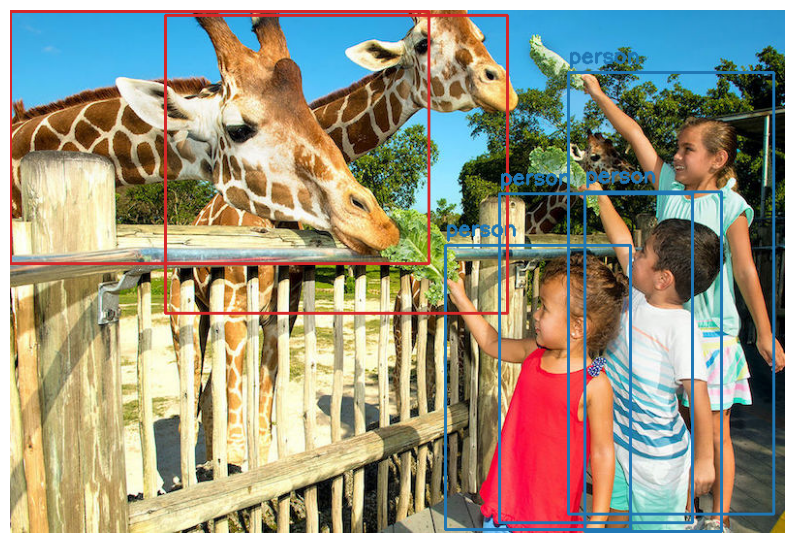

In [ ]:
run_and_show(retinanet, image_example, 0.5, coco_class_to_label_map, verbose=True)

---

#### 3. Дообучение RetinaNet

Наконец, убедимся в том, что наша модель может обучаться.

У нас есть кусок датасета [OpenImages](https://storage.googleapis.com/openimages/web/index.html), которая содержит примеры класса `Ball`.
Будем обучать нашу модель детектировать 1 класс - мячи, шары и т.д.


Подгрузка данных:

In [ ]:
# %reload_ext autoreload

import tqdm

from torchvision import transforms
from torch.utils.data import DataLoader

from dataset import DetectionDataset

from retinanet.dataloader import Normalizer, Resizer, Augmenter, collater, AspectRatioBasedSampler, UnNormalizer

#### Аугментации

В задачах компьютерного зрения от набора обучающих данных зависит качество работы сети. Данных требуется много и хочется, чтобы они были наиболее разнородными. Собирать новые данные дорого и долго, поэтому часто используют аугментацию изображений.

Аугментация — создание новых данных на основе какого-то базиса. Можно взять несколько шаблонов / «идеальных» примеров (те данные, которые есть) и с помощью различных искажений расширить набор изображений.
Можно использовать следующие искажения:
* Геометрические (афинные, проективные, ...).
* Яркостные/цветовые.
* Замена фона.
* Искажения, характерные для решаемой задачи: блики, шумы, размытие и т. д.

Популярные библиотеки для аугментации изображений:
* https://pytorch.org/vision/stable/transforms.html
* https://albumentations.ai

![overall](https://github.com/stepanovnick/dl-course/blob/main/lecture6/workshop_detection/images/img9_aug.jpeg?raw=1)

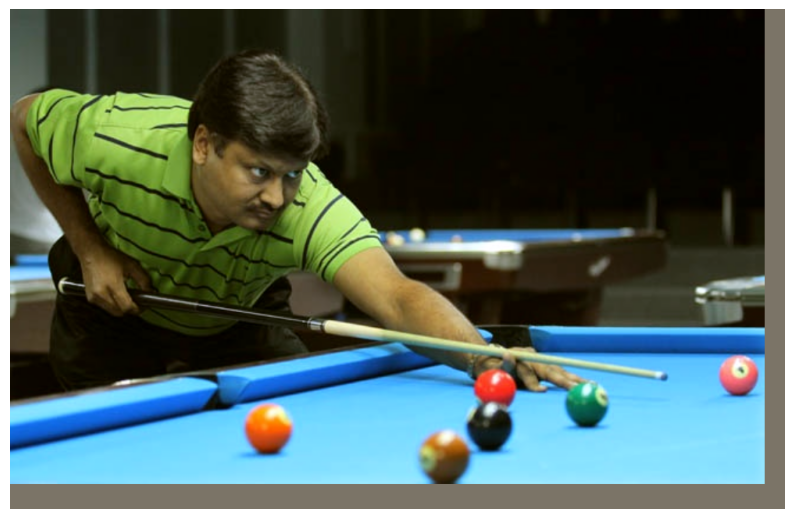

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

example_transforms = transforms.Compose([
    Normalizer(),
    Resizer()
])
example_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                                 transforms=example_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
iterator = iter(example_dataset)
exp_img = next(iterator)['img']
inv_tensor = inv_normalize(exp_img.permute(2,1,0))
show_image(inv_tensor.permute(2,1,0).numpy())

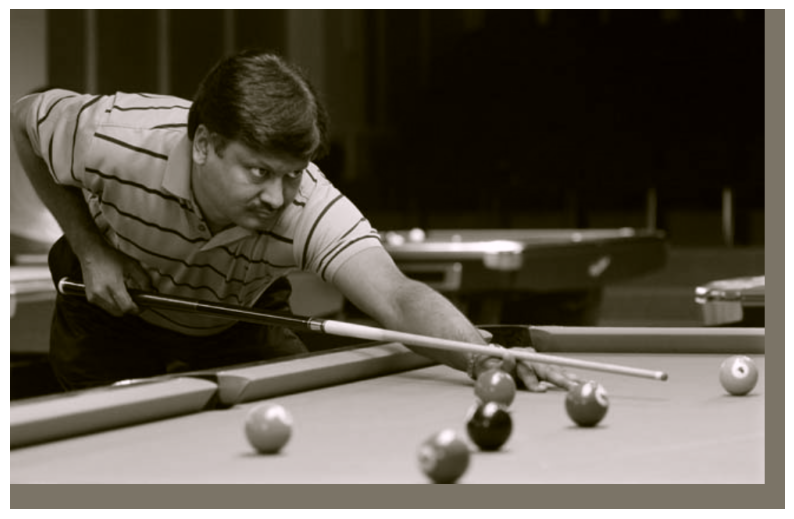

In [ ]:
class RandomGrayscale:

    def __init__(self, p = 1):
        self.proba = p
        self.to_gray = transforms.RandomGrayscale(p=self.proba)

    def __call__(self, sample):

        image, annots = sample['img'], sample['annot']
        image = self.to_gray(image.permute(2,1,0))
        return {'img':image, 'annot': annots}

example_transforms = transforms.Compose([
    Normalizer(), Resizer(), RandomGrayscale(),
])
example_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                                 transforms=example_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
iterator = iter(example_dataset)
exp_img = next(iterator)['img']
inv_tensor = inv_normalize(exp_img)
show_image(inv_tensor.permute(2,1,0).numpy())

In [ ]:
train_transforms = transforms.Compose([
    Normalizer(), Augmenter(), Resizer()
])

val_transforms = transforms.Compose([
    Normalizer(), Resizer()
])

Теперь к созданию датасетов и даталоадеров.

Обратите внимание на `AspectRatioBasedSampler`:
* Для обучения моделей в `pytorch` необходимо, чтобы все элементы в батче были одного размера.
* Поскольку мы учим полносверточную архитектуру на полных изображениях (а не на кропах, как в классификации), то нам нужно отресайзить их к одному размеру.
Если у изображений разное соотношение сторон, мы будем добавлять рамки (padding).
* `AspectRatioBasedSampler` группирует изображения в датасете таким образом, чтобы в батч попадали изображения с как можно более похожим соотношением сторон, чтобы не делать слишком большие паддинги.

Датасеты устроены так, чтобы возвращать тензор изображения и тензор аннотаций к нему.

In [ ]:
train_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_train.json",
                                 transforms=train_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
train_sampler = AspectRatioBasedSampler(train_dataset, batch_size=4, drop_last=False) # deepdive
train_dataloader = DataLoader(train_dataset, num_workers=8, collate_fn=collater, batch_sampler=train_sampler)

val_dataset = DetectionDataset(data_dict_file="./seminar_objdet_retina_oi5_ball/oi5_ball_filename_to_bbox_val.json",
                               transforms=val_transforms, add_path = './seminar_objdet_retina_oi5_ball/')
val_sampler = AspectRatioBasedSampler(val_dataset, batch_size=4, drop_last=False)
val_dataloader = DataLoader(val_dataset, num_workers=8, collate_fn=collater, batch_sampler=val_sampler)

In [ ]:
item = train_dataset[0]
print(item["img"].size())    # H x W x 3
print(item["annot"].size())  # N x 5; 4 coords + 1 label.

torch.Size([640, 992, 3])
torch.Size([6, 5])


Теперь непосредственно к модели.

Во-первых, нужно заменить головы для классификации и регрессии для дообучения.
При этом у классификационной головы нужно указать число классов - 1.

In [ ]:
retinanet.classification_head = ClassificationModel(num_features_in, num_classes=1)
retinanet.regression_head = RegressionModel(num_features_in)
retinanet.to(device);

Во-вторых, потребуется функция для переключения модулей нашей сети в режим обучения; сделаем так, чтобы можно было учить отдельные модули.

**Вопрос**: зачем "замораживать" BN?

In [ ]:
def set_to_training(model, backbone=False, fpn=False, regression_head=True, classification_head=True, freeze_bn=False):
    model.train()
    model.requires_grad_(True)

    if not backbone:
        model.backbone.eval()
        model.backbone.requires_grad_(False)

    elif freeze_bn:
        for layer in model.backbone.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    if not fpn:
        model.fpn.eval()
        model.fpn.requires_grad_(False)

    if not regression_head:
        model.regression_head.eval()
        model.regression_head.requires_grad_(False)

    if not classification_head:
        model.classification_head.eval()
        model.classification_head.requires_grad_(False)

И простая функция для обучения на 1 эпохе.

In [ ]:
import numpy as np
from mean_average_precision import MetricBuilder
import gc

In [ ]:
def val_step(model, dataloader):
    model.eval()
    metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=False, num_classes=1)
    for iter_num, data in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
      for img, gt in zip(data['img'], data['annot']):
        with torch.no_grad():
          nms_scores, nms_classes, bboxes = model(img.unsqueeze(0))
        preds = torch.cat([bboxes, nms_classes.unsqueeze(0).T, nms_scores.unsqueeze(0).T], dim = 1).cpu().detach().numpy()
        zeros = torch.zeros((gt.shape[0], 1))
        gt = torch.cat([gt, zeros, zeros], 1).cpu().detach().numpy()
        metric_fn.add(preds, gt)

        del img, gt, preds, zeros, nms_scores, nms_classes, bboxes
      gc.collect()
      torch.cuda.empty_cache()
    print(f"validation mAP in all points: {metric_fn.value(iou_thresholds=0.5)['mAP']}")


def routine(retina_model, scheduler, train_loader, val_loader):
    epoch_loss = []
    torch.cuda.empty_cache()
    for iter_num, data in tqdm.tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

        optimizer.zero_grad()

        classification_loss, regression_loss = retina_model([data['img'].to(device).float(), data['annot'].to(device)])
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()

        loss = classification_loss + regression_loss

        if bool(loss == 0):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(retina_model.parameters(), 0.1)
        optimizer.step()

        epoch_loss.append(float(loss.item()))
        del data

    gc.collect()
    torch.cuda.empty_cache()

    print('Epoch: {} | Iteration: {} | Train classification loss: {:1.5f} | train regression loss: {:1.5f} | Epoch loss: {:1.5f}'\
          .format(epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(epoch_loss)))
    scheduler.step(np.mean(epoch_loss)) # should be val loss

Сначала обучим только новые головы в течение 1 эпохи:

In [ ]:
set_to_training(retinanet, backbone=False, fpn=False, regression_head=True, classification_head=True, freeze_bn=True)

In [ ]:
params = [p for p in retinanet.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, )

In [ ]:
epochs = 1
for epoch_num in range(epochs):
    routine(retinanet, scheduler, train_dataloader, val_dataloader)

  5%|▍         | 34/719 [1:29:25<30:14:54, 158.97s/it]

In [ ]:
val_step(retinanet, val_dataloader)

И потом обучим всю сеть (с "замороженными" BN) - уже подольше.

In [ ]:
set_to_training(retinanet, backbone=True, fpn=True, regression_head=True, classification_head=True, freeze_bn=False)

In [ ]:
params = [p for p in retinanet.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [ ]:
epochs = 4
for epoch_num in range(epochs):
    routine(retinanet, scheduler, train_dataloader, val_dataloader)

    if epoch_num % 10 == 0 or epoch_num + 1 == epochs:
        torch.save(retinanet.state_dict(), f"dev_balls_retinanet_{epoch_num}.pt")

In [ ]:
val_step(retinanet, val_dataloader)

Для иллюстрации результатов выберем случайные изображения из выборки и отрисуем предсказания.

In [ ]:
with open("./seminar_objdet_retina_oi5_ball/oi5_ball_retinanet_ep=10.pt", "rb") as fp:
    state_dict = torch.load(fp, map_location="cpu")
retinanet.load_state_dict(state_dict)

In [ ]:
retinanet.eval();

In [ ]:
val_step(retinanet, val_dataloader)

In [ ]:
for i in range(10):
    index = np.random.randint(len(train_dataset))
    tensor = train_dataset[index]["img"].unsqueeze(0)
    run_and_show(retinanet, tensor, 0.5, {0: "ball"}, verbose=True)

Пример из валидации:

In [ ]:
for i in range(10):
    index = np.random.randint(len(val_dataset))
    tensor = val_dataset[index]["img"].unsqueeze(0)
    run_and_show(retinanet, tensor, 0.5, {0: "ball"}, verbose=True)

### Резюме

Если бы мы учили детектор для какой-то конкретной задачи, то:

1. Учились бы на нескольких `GPU` (для адекватного размера батча)
2. Более аккуратно подбирали якорные боксы
3. По возможности использовали библиотечные модели (а не кустарные)

### Домшниее задание

Решить задачу детекции мячей с помощью другой модели
1. потребуется загрузить предобученную модель: https://pytorch.org/vision/stable/models.html , https://paperswithcode.com/sota/object-detection-on-coco
2. Создать класс датасета и даталоадера
3. Добавить аугментаций
4. Дообучить несколько эпох и посмотреть на качество